# Project Title   : Network Analysis based on Genshin Impact

----

In [ ]:
pip install networkx

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import json
import plotly.express as px
import pandas as pd
import numpy as np

## 1. Load nodes and edges from JSON file

In [ ]:
nodes = json.load(open('/content/edge_list.json', 'rb'))
edges = json.load(open('/content/edge_list.json', 'rb'))

In [ ]:
# example look of the node_list JSON file
nodes[1]

{'id': 'Keqing', 'nation': 'Liyue'}

In [ ]:
# example look of the edge_list JSON file
edges[1]

{'from': 'Amber', 'to': 'Klee', 'type': 'voice'}

## 2. Creating directed graph

In [ ]:
%%time

directed_graph = nx.DiGraph()

# add characters with a nation attribute
for node in nodes:
    directed_graph.add_node(node['id'], nation=node['nation'])

# add character relations
for edge in edges:
    directed_graph.add_edge(edge['from'], edge['to'], type=edge['type'])

CPU times: user 745 µs, sys: 0 ns, total: 745 µs
Wall time: 1.11 ms


## 3. Visualize the Genshin Impact character network

### 3.1 Create the `node_colors` list for displaying node with colors based on nation

In [ ]:
# setting node colours for drawing
nation_color_dict = {
    'Mondstadt': '#aff8db',
    'Liyue': '#ffcbc1',
    'Inazuma': '#d5aaff',
    'Snezhnaya': '#ace7ff'
}

# for each node, assign the node a color based on the
# the color map dictionary if the nation is existed in 
# the color map dictionary
node_colors = []
for node, nation in list(directed_graph.nodes(data="nation")):
    if nation in nation_color_dict:
        node_colors.append(nation_color_dict[nation])
    else:
        node_colors.append('#FFA500') # traveler doesn't belong to any nation

### 3.2 Spring layout visualization of the Genshin Impact character network

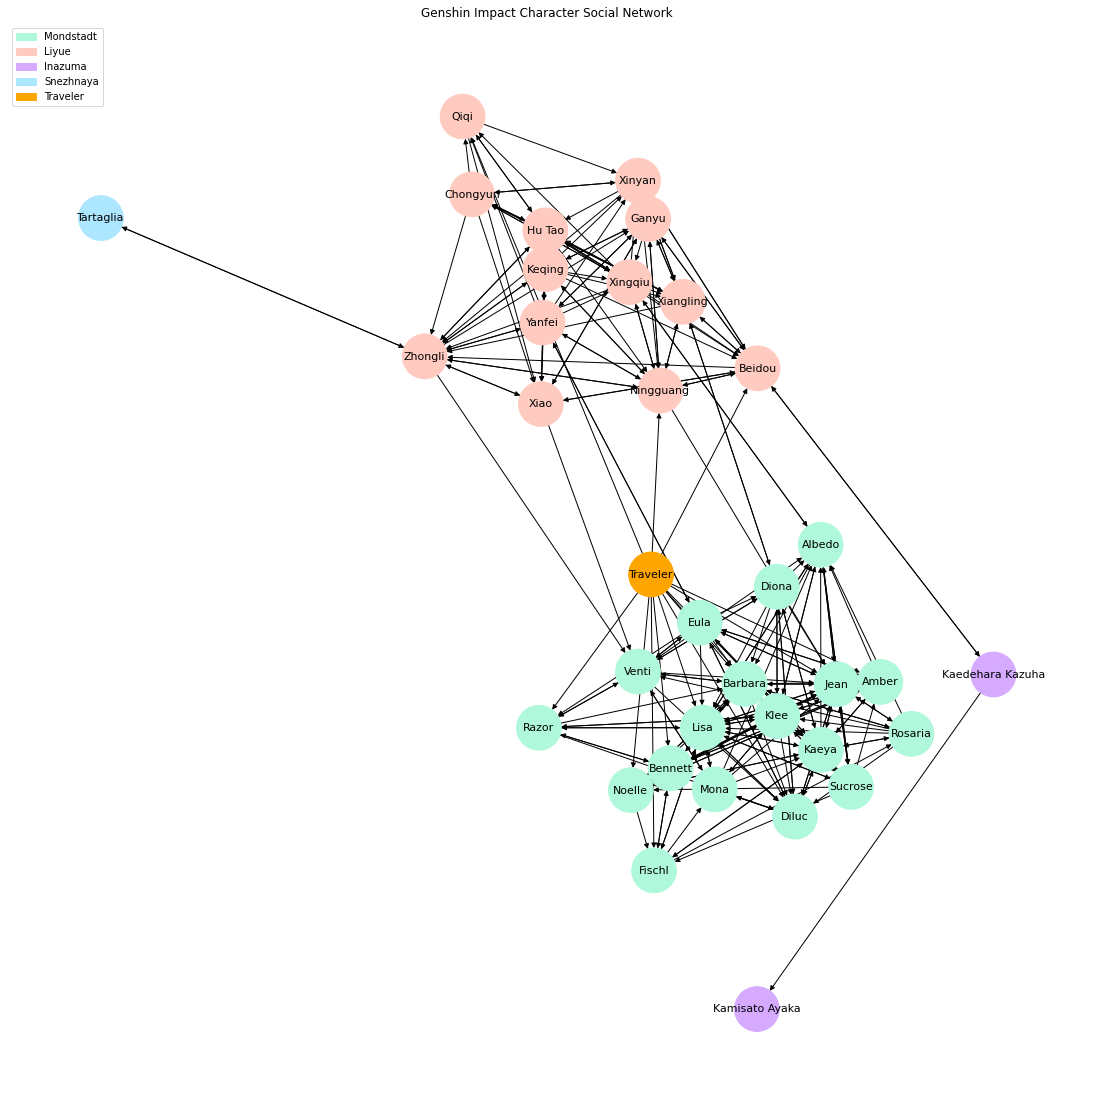

CPU times: user 1.66 s, sys: 222 ms, total: 1.88 s
Wall time: 1.69 s


In [ ]:
%%time

# create spring layout for 25 iterations to separate the nodes
np.random.seed(2021)
pos = nx.spring_layout(directed_graph, k=0.3, iterations=25)

plt.figure(1,figsize=(15,15)) 
nx.draw(directed_graph,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend and show the plot
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya"),
                mpatches.Patch(color="#FFA500", label="Traveler"),
               ]

plt.title("Genshin Impact Character Social Network")
plt.legend(handles=legend_tiles, loc="upper left")
plt.show()
# uncomment to save picture
# plt.savefig('directed.png')

In [ ]:
# function to get subgraph from node filter
def get_subgraph_by_nation(graph, target_nation="Mondstadt"):
    node_to_filter = []
    for node, nation in list(graph.nodes(data="nation")):
        if target_nation == nation:
            node_to_filter.append(node)
    return node_to_filter, graph.subgraph(node_to_filter)

# function to assign color for node visualization
def create_node_colors_from_graph(graph, nation_color_dict):
    node_colors = []
    for node, nation in list(graph.nodes(data="nation")):
        if nation in nation_color_dict:
            node_colors.append(nation_color_dict[nation])
    return node_colors

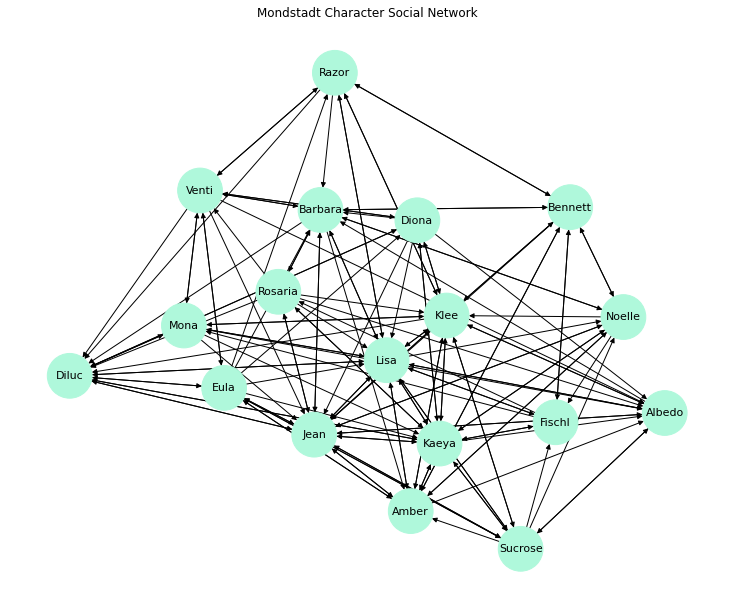

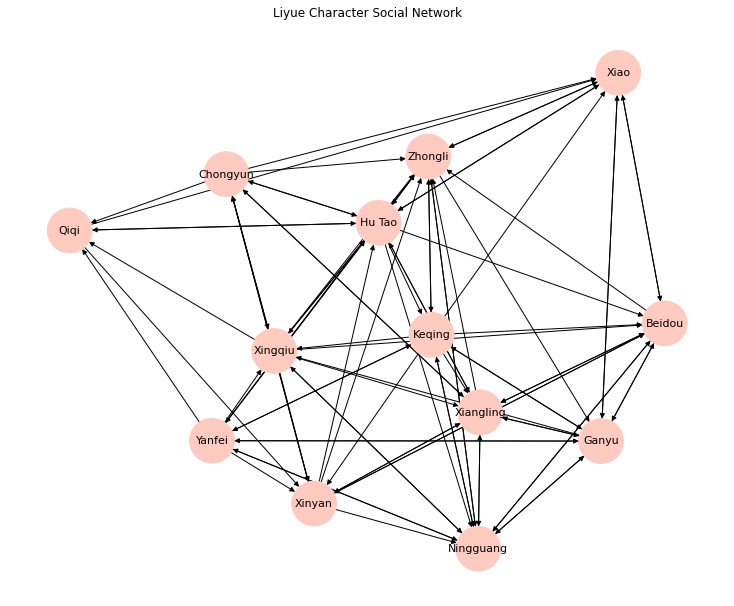

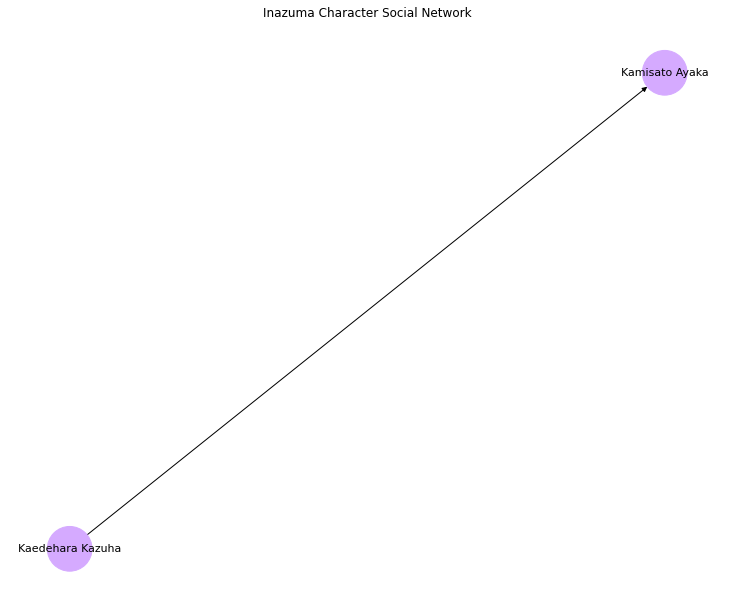

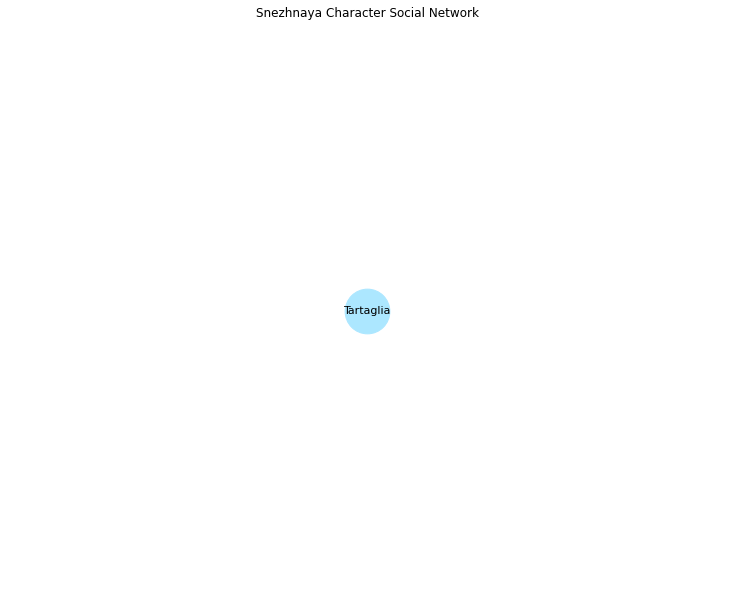

In [ ]:
for target_nation in nation_color_dict.keys():
    filtered_nodes, subgraph = get_subgraph_by_nation(directed_graph, target_nation=target_nation)

    np.random.seed(2021)
    pos = nx.spring_layout(subgraph, k=0.3, iterations=25)
    node_colors = create_node_colors_from_graph(subgraph, nation_color_dict)
    plt.figure(1,figsize=(10,8)) 
    nx.draw(subgraph,
            pos = pos,
            node_color=node_colors,
            node_size=2000,
            with_labels=True,
            font_size = 11,
            font_color='black')
    plt.title(target_nation + " Character Social Network")
    plt.show()

------



#Description Statistics:


##4. Tradic Closure
The tendency for people who share connections in a social network to become connected

###4.1 Local Clustering Coefficient (LCC)
Definition: Fractions of pairs of the node’s friends are friends with each other

Interpretation: How likely a node’s friends are connected to each other

In [ ]:
# get the local cluster coefficient dataframe
def get_local_cluster_coefficient(graph):
    LCC_df = pd.DataFrame(sorted(nx.clustering(graph).items(), 
                                 key=lambda item: -item[1]), 
                      columns=["node", "LCC"])
    return LCC_df

In [ ]:
# find nodes with LCC score of > 0.5:
# means that > 50% of change a node n's friends are friends of each other
node_data = dict(directed_graph.nodes(data="nation"))
LCC_df = get_local_cluster_coefficient(directed_graph)
LCC_df["nation"] = [node_data[node] for node in LCC_df["node"]]

# output the dataframe of LCC
print(round(100 * len(LCC_df.query("LCC > 0.5")) / len(LCC_df), 1),
      "% of the nodes have Local Cluster Coefficients > 0.5")
LCC_df.query("LCC > 0.5")

31.4 % of the nodes have Local Cluster Coefficients > 0.5


,node,LCC,nation
0,Sucrose,0.691919,Mondstadt
1,Keqing,0.660920,Liyue
2,Noelle,0.640000,Mondstadt
3,Rosaria,0.611111,Mondstadt
4,Amber,0.609589,Mondstadt
5,Chongyun,0.598039,Liyue
6,Ganyu,0.594118,Liyue
7,Mona,0.572581,Mondstadt
8,Xinyan,0.546667,Liyue
9,Diluc,0.537415,Mondstadt


In [ ]:
LCC_df.nation.value_counts()

Mondstadt    18
Liyue        13
Inazuma       2
NA            1
Snezhnaya     1
Name: nation, dtype: int64

###Based on the current LCC output, we can observe that Sucrose is the character with highest LCC = 0.69. It means that 69% of Sucrose's connections are also connected with each other.

###Let's look at the sub graph with Sucrose's connections below:

In [ ]:
# function to return a node's neighbor nodes as a list
def get_neighbors(graph, node):
    return [n for n in graph.neighbors(node)]

Neighbors of node Sucrose: ['Eula', 'Lisa', 'Noelle', 'Klee', 'Albedo', 'Fischl', 'Kaeya', 'Amber', 'Jean']


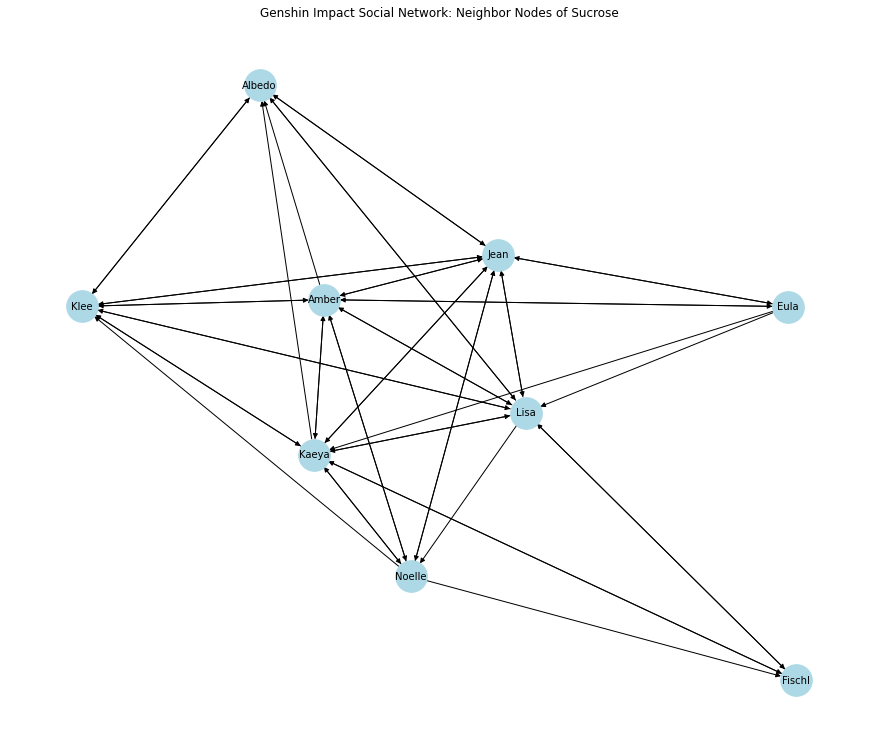

In [ ]:
neighbor_nodes = get_neighbors(directed_graph, "Sucrose")
print("Neighbors of node Sucrose:", neighbor_nodes)

# get subgraph
subgraph = directed_graph.subgraph(neighbor_nodes)

# create visualization
pos = nx.spring_layout(subgraph, 
                       k=0.3, iterations=50,
                       seed=2)

plt.figure(1,figsize=(12,10)) 
nx.draw(subgraph,
        pos = pos,
        node_size=1000,
        node_color="lightblue",
        with_labels=True,
        font_size = 10,
        font_color='black')
plt.title("Genshin Impact Social Network: Neighbor Nodes of Sucrose")
plt.show() 

###4.2 Global Clustering Coefficient (GCC)
Definition: Measuring how likely the nodes are going to cluster on the whole network
####4.2.1 Average local clustering coefficient:
Definition: Average local clustering coefficient over all nodes in the graph.

Interpretation: Overall, what’s the probability of adjacent nodes being connected.

In [ ]:
# compute using the already calculated LCC dataframe
np.mean(LCC_df["LCC"])

0.4492437134000257

In [ ]:
# compute using the average_clustering() function
nx.average_clustering(directed_graph)

0.44924371340002567

###Overall, the probability of adjacent nodes being connected is 44.92%, which is below 50%.

-----


##5. Connectivity:
###5.1 Strongly connected:
Definition: for every pair nodes u and v,there is
a directed path from u to v and
a directed path from v to u.

Interpretation: Are all the nodes reachable from every other node in the network?

In [ ]:
# find whether a graph is strongly connected or not
print("Are all the nodes reachable from every other node in the network?",
      nx.is_strongly_connected(directed_graph))

Are all the nodes reachable from every other node in the network? False


###We can't reach all the nodes from every other node in the network. Because of this, we are unable to calculate the eccentricity because it requires checking all the path between any node a and any node b.

###5.2 Weakly connected:
Definition: a directed graph is weakly connected if replacing all directed edges with undirected edges produces a connected undirected graph

Interpretation: If not considering the direction of the connections, is the graph is connected?

In [ ]:
# find whether a graph is weakly connected or not
print("If not considering the direction of the connections, is the graph is connected?",
      nx.is_weakly_connected(directed_graph))

If not considering the direction of the connections, is the graph is connected? True


###The directed graph is weakly connected. It means that there is only one connected component if we consider the graph as undirected.

------


##6. Distance Measures
Measuring the length of the shortest path between a node A and a node B.

###6.1 Average Distance (Average Shortest Path Length)
Definition: the average shortest path of all the connected node pairs.

Interpretation: On average, how far away the nodes are from each other.

In [ ]:
math.ceil(nx.average_shortest_path_length(directed_graph))

3

###On average, the nodes are 3 steps from each other.

###6.2 Eccentricity
Definition: For a node n, eccentricity is the largest distance between n and all other nodes.

Interpretation: For each node, what’s the most far away distance to connect a node

In [ ]:
# get the local cluster coefficient dataframe
def get_eccentricity_df(graph):
    try:
        nx.is_strongly_connected(directed_graph)
        eccentricity_df = pd.DataFrame(sorted(nx.eccentricity(graph).items(), 
                                       key=lambda item: -item[1]), 
                                       columns=["node", "eccentricity"])
        return eccentricty_df
    except:
        print("Unable to find eccentricity for not strongly connected directed graph")
        return []
# get sorted accentricty df
eccentricity_df = get_eccentricity_df(directed_graph)

Unable to find eccentricity for not strongly connected directed graph


###In the network, the network is not strongly connected. Hence, we can't find the eccentricty, radius, diameter, center, and periphery because the requirement for a graph being strongly connected.

##7. Robustness Measures
The ability of a network to maintain its general structural properties when it faces failures or attacks.

###7.1 Density
Definition: The ratio between the count of existing edges and all the possible edges’ count

Interpretation: 
a. How many percent of the total possible edges are observed in a given network; help us understand how connected the network is compared to how connected it might be.
b. Second, when comparing two networks with the same number of nodes and the same type of relationships, it can tell us how the networks are different.
c. Graphs with large node and edge connectivity are more robust to the loss of nodes and edges

In [ ]:
nx.density(directed_graph)

0.22016806722689075

###The density of graph is 0.22. It implies the graph has 22% of the total possible edges are observed in the network.
###7.2 Node Connectivity and Minimum Node Cut:
Question: Minimum number of nodes to remove to disconnect a graph?
Which nodes can be removed to disconnect a graph?

In [ ]:
nx.node_connectivity(directed_graph)

0

In [ ]:
nx.minimum_node_cut(directed_graph)

set()

###Because of the network is not strongly connected, the minimum number of node to remove for disconnecting a graph is 0. Now, let's only look at nodes with mutual connections.

In [ ]:
mutual_connection = directed_graph.to_undirected(reciprocal=True)

In [ ]:
mutual_connection.degree()

DegreeView({'Xinyan': 3, 'Keqing': 4, 'Bennett': 6, 'Xiangling': 7, 'Zhongli': 6, 'Kaeya': 10, 'Klee': 10, 'Mona': 4, 'Yanfei': 5, 'Chongyun': 4, 'Diluc': 6, 'Kamisato Ayaka': 0, 'Ningguang': 7, 'Xingqiu': 4, 'Eula': 6, 'Beidou': 6, 'Albedo': 5, 'Amber': 7, 'Ganyu': 6, 'Barbara': 6, 'Rosaria': 3, 'Sucrose': 6, 'Hu Tao': 6, 'Kaedehara Kazuha': 1, 'Lisa': 11, 'Traveler': 0, 'Xiao': 4, 'Qiqi': 1, 'Venti': 5, 'Diona': 5, 'Fischl': 3, 'Noelle': 5, 'Razor': 4, 'Tartaglia': 1, 'Jean': 11})

In [ ]:
# find isolates
isolates = list(nx.isolates(mutual_connection))
isolates

['Kamisato Ayaka', 'Traveler']

In [ ]:
def get_directed_graph_node_degree(graph, node):
    print("\n- Degree statistics for", node)
    print(node, "in-degree:", graph.in_degree(node))
    print(node, "out-degree:", graph.out_degree(node))

get_directed_graph_node_degree(directed_graph, "Traveler")
get_directed_graph_node_degree(directed_graph, "Kamisato Ayaka")


- Degree statistics for Traveler
Traveler in-degree: 0
Traveler out-degree: 14

- Degree statistics for Kamisato Ayaka
Kamisato Ayaka in-degree: 1
Kamisato Ayaka out-degree: 0


###From the above isolate output, we can see Ayaka and Traveler don't have mutual connections like other characters. traveler mentioned other characters 14 times, but traveler is not mentioned by any existing character. Ayaka is mentioned by 1 character, but she didn't mention anyone else yet.

In [ ]:
# create subgraph using the mutually connected nodes
mutual_connection.remove_nodes_from(isolates)


In [ ]:
# get the mutual connection subgraph
mutual_connection_subgraph = directed_graph.subgraph(list(mutual_connection.nodes()))


In [ ]:
 # create node color list for visualization
mutual_connected_node_colors = []
for node, nation in list(mutual_connection_subgraph.nodes(data="nation")):
    if nation in nation_color_dict:
        mutual_connected_node_colors.append(nation_color_dict[nation])
    else:
        mutual_connected_node_colors.append('#FFA500') # traveler doesn't belong to any nation


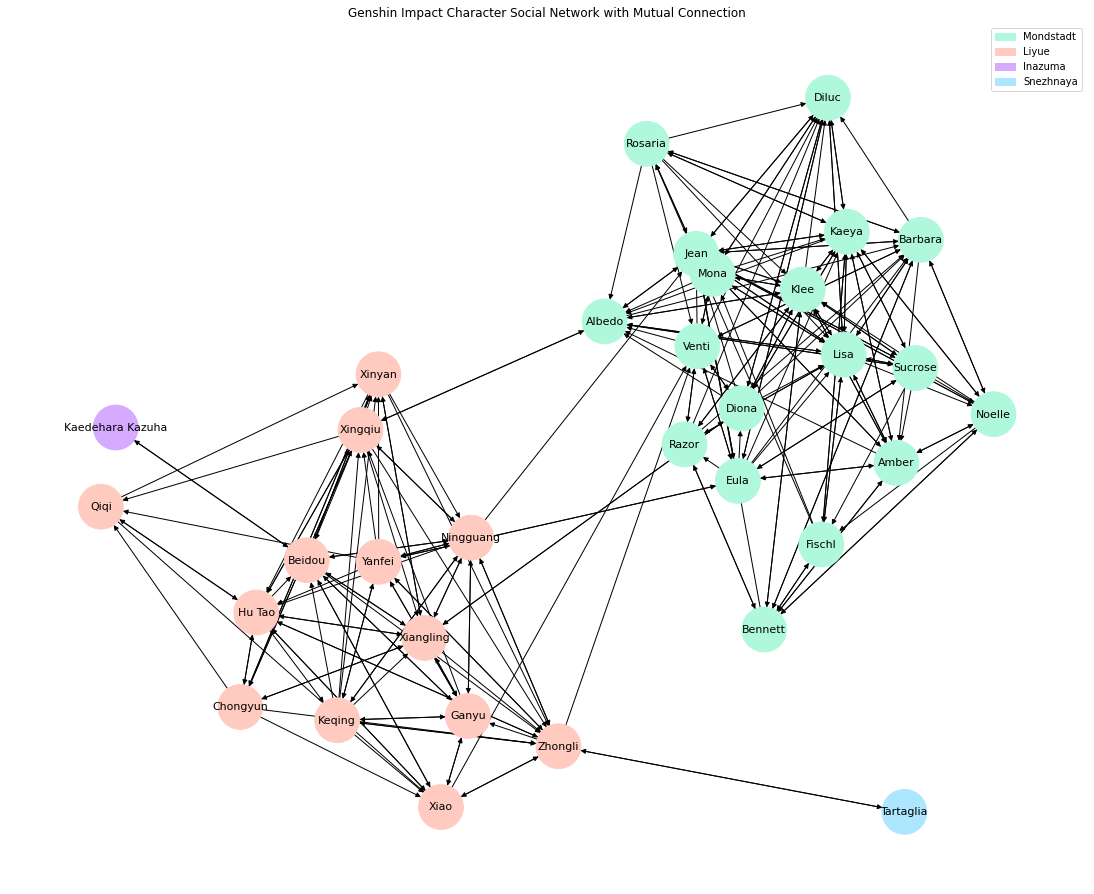

CPU times: user 1.59 s, sys: 229 ms, total: 1.82 s
Wall time: 1.59 s


In [ ]:
%%time

# create spring layout for 25 iterations to separate the nodes
pos = nx.spring_layout(mutual_connection_subgraph, k=0.5, iterations=25, seed=1)

plt.figure(1,figsize=(15,12)) 
nx.draw(mutual_connection_subgraph,
        pos = pos,
        node_size=2000,
        node_color=mutual_connected_node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend and show the plot
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya")
               ]

plt.title("Genshin Impact Character Social Network with Mutual Connection")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()
# uncomment to save picture
# plt.savefig('directed.png')

###We can see Ayaka and Traveler are removed from the network because they don't have any mutual connection.

In [ ]:
nx.node_connectivity(mutual_connection_subgraph)

1

In [ ]:
nx.minimum_node_cut(mutual_connection_subgraph)

{'Beidou'}

###Seems like Beidou is the character that will disconnect the network. Let's make a copy of the network, and plot the graph after removing Beidou.

In [ ]:

temp_copy = mutual_connection_subgraph.copy()
temp_copy.remove_nodes_from(["Beidou"])
temp_copy.nodes()

NodeView(('Xinyan', 'Keqing', 'Bennett', 'Xiangling', 'Zhongli', 'Kaeya', 'Klee', 'Mona', 'Yanfei', 'Chongyun', 'Diluc', 'Ningguang', 'Xingqiu', 'Eula', 'Albedo', 'Amber', 'Ganyu', 'Barbara', 'Rosaria', 'Sucrose', 'Hu Tao', 'Kaedehara Kazuha', 'Lisa', 'Xiao', 'Qiqi', 'Venti', 'Diona', 'Fischl', 'Noelle', 'Razor', 'Tartaglia', 'Jean'))

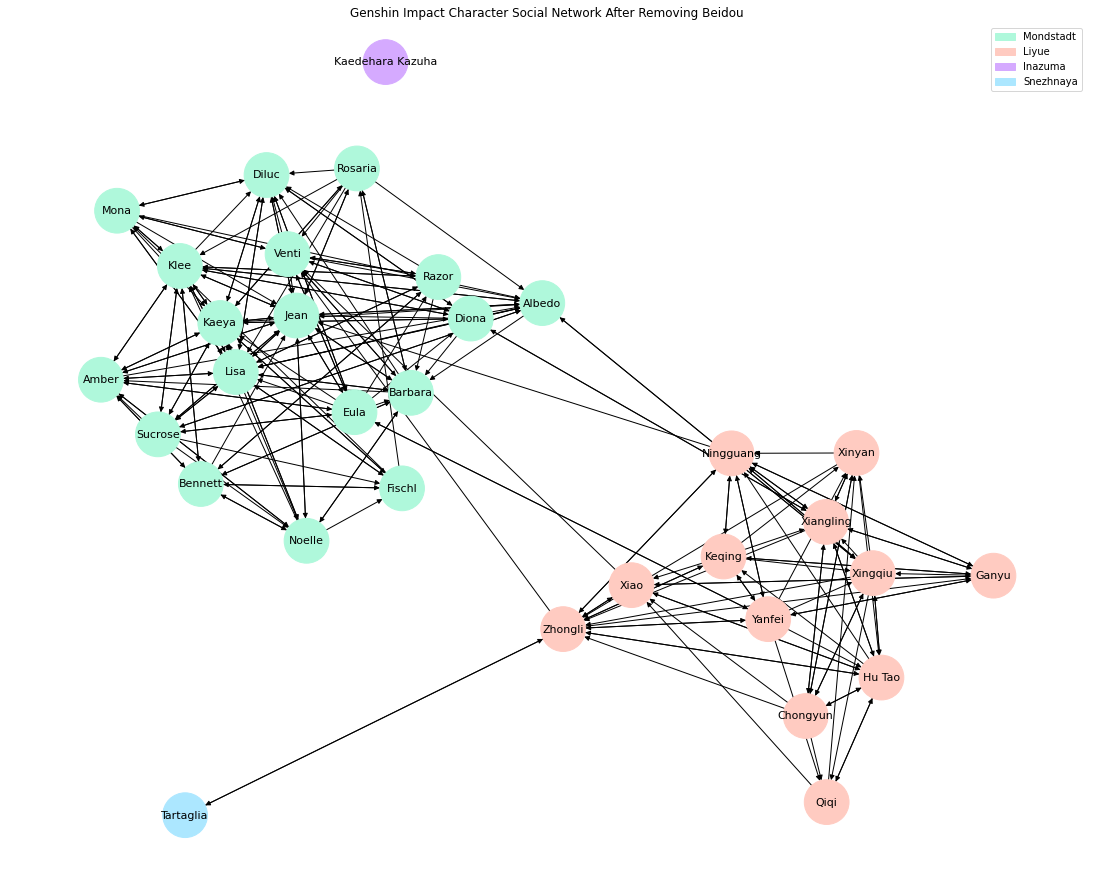

In [ ]:
# create node color list for visualization
mutual_connected_node_colors = []
for node, nation in list(temp_copy.nodes(data="nation")):
    if nation in nation_color_dict:
        mutual_connected_node_colors.append(nation_color_dict[nation])
    else:
        mutual_connected_node_colors.append('#FFA500') # traveler doesn't belong to any nation
        
# create spring layout for 25 iterations to separate the nodes
pos = nx.spring_layout(temp_copy, k=0.5, iterations=25, seed=1)

plt.figure(1,figsize=(15,12)) 
nx.draw(temp_copy,
        pos = pos,
        node_size=2000,
        node_color=mutual_connected_node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend and show the plot
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya")
               ]

plt.title("Genshin Impact Character Social Network After Removing Beidou")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()
# uncomment to save picture
# plt.savefig('directed.png')

###After removing Beidou, the connection between Beidou and Kazuha is removed. Hence, the network is disconnected. The same process can be applied to Zhongli to disconnect Tartaglia from the network.
###7.3 Edge Connectivity and Minimum Edge Cut:
Question: Minimum number of edges to remove to disconnect a graph?

Which edges can be removed to disconnect a graph?

In [ ]:
nx.edge_connectivity(mutual_connection_subgraph)

1

In [ ]:
nx.minimum_edge_cut(mutual_connection_subgraph)

{('Tartaglia', 'Zhongli')}

In [ ]:
temp_copy = mutual_connection_subgraph.copy()
temp_copy.remove_edges_from({('Tartaglia', 'Zhongli')})

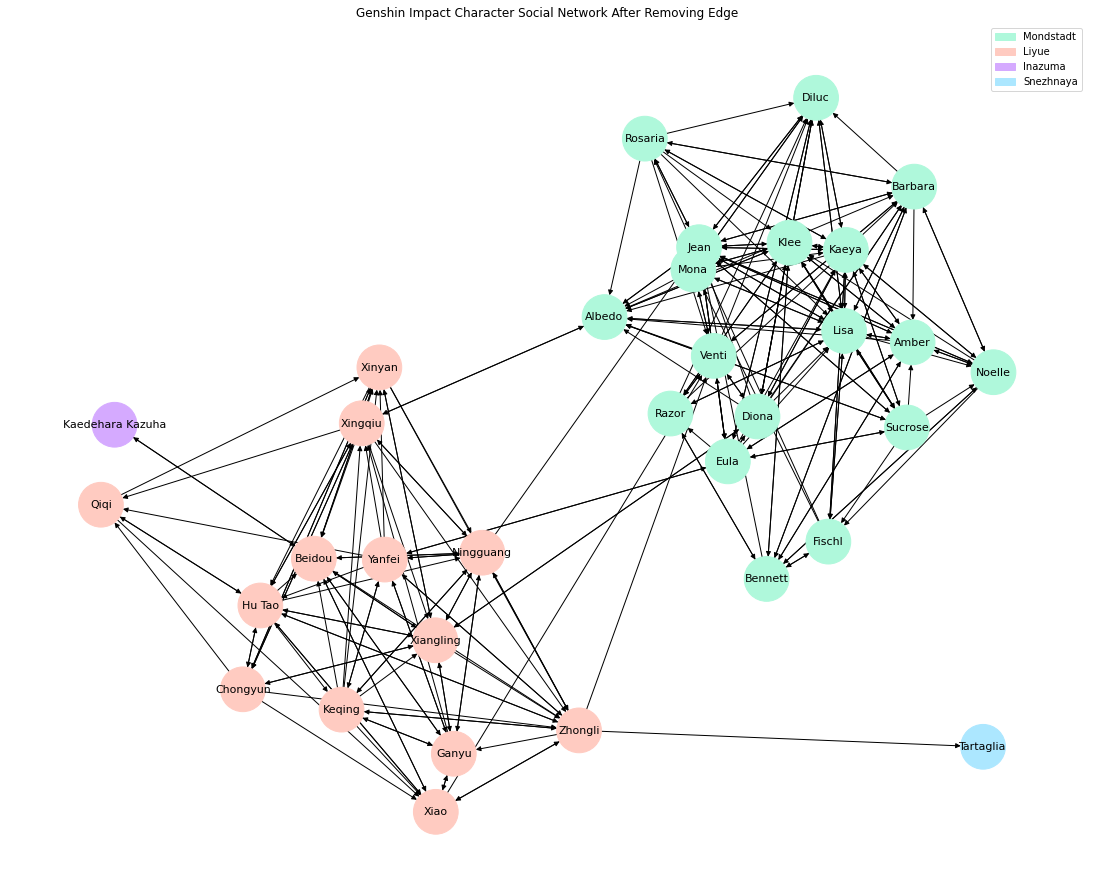

In [ ]:
# create node color list for visualization
mutual_connected_node_colors = []
for node, nation in list(temp_copy.nodes(data="nation")):
    if nation in nation_color_dict:
        mutual_connected_node_colors.append(nation_color_dict[nation])
    else:
        mutual_connected_node_colors.append('#FFA500') # traveler doesn't belong to any nation
        
# create spring layout for 25 iterations to separate the nodes
pos = nx.spring_layout(temp_copy, k=0.5, iterations=25, seed=1)

plt.figure(1,figsize=(15,12)) 
nx.draw(temp_copy,
        pos = pos,
        node_size=2000,
        node_color=mutual_connected_node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend and show the plot
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya")
               ]

plt.title("Genshin Impact Character Social Network After Removing Edge")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()

###After removing the directed edge connected from Tartaglia to Zhongli, the directed network is disconnected.

------

## 8. Centrality / Node Importance
What characterizes an important node?

### 8.1 Degree centrality (local importance)

1. Assumption: important nodes have many connections.
2. Definition: measure node n’s importance by the degree of node n over total number of nodes
3. Interpretation: which node is the most important one with the most number of connections/friends/followers?

### Since the graph is directed, we will have in-degree and out-degree centrality.

In [ ]:
in_degree_centrality_df = pd.DataFrame(nx.in_degree_centrality(directed_graph).items(), 
                                       columns=["node", "in_degree_centrality"])
in_degree_centrality_df.sort_values("in_degree_centrality", ascending=False).head(10)

,node,in_degree_centrality
34,Jean,0.500000
24,Lisa,0.441176
5,Kaeya,0.382353
6,Klee,0.382353
10,Diluc,0.352941
19,Barbara,0.323529
4,Zhongli,0.323529
16,Albedo,0.323529
15,Beidou,0.294118
12,Ningguang,0.294118


### Jean has the highest in-degree centrality. This implies Jean is mostly mentioned by other character in their storyline and voice memo.

In [ ]:
# for a given graph and an important node,
# return suitable node color list for visualization
def get_centrality_node_colors(graph, important_node):
    node_colors = ["#EFD1BB"] * len(graph.nodes())
    node_colors[list(graph.nodes()).index(important_node)] = "#F47315"
    return node_colors

In [ ]:
out_degree_centrality_df = pd.DataFrame(nx.out_degree_centrality(directed_graph).items(), 
                                       columns=["node", "out_degree_centrality"])
out_degree_centrality_df.sort_values("out_degree_centrality", ascending=False).head(10)

,node,out_degree_centrality
25,Traveler,0.411765
24,Lisa,0.352941
34,Jean,0.323529
5,Kaeya,0.323529
6,Klee,0.323529
14,Eula,0.323529
1,Keqing,0.264706
29,Diona,0.264706
8,Yanfei,0.264706
22,Hu Tao,0.264706


### If we look at out-degree centrality, Traveler is the most important character to connect to the rest of the intermediate characters. It makes sense because Traveler is the main character visiting different regions to connect the storylines. 

### 8.2 Closeness centrality (path spread importance)

1. Assumption: important nodes are close to other nodes
2. Definition: normalize the total shortest path lengths between the node n and all other nodes in the graph by the N-1 number of nodes in the network.
![image.png](attachment:image.png)
3. Interpretation: 
    * smaller total shortest path lengths of a node n to all other nodes will result in larger centrality value; hence, the closer it is to all other nodes, the more central a node is.
    * In social networks, we wanted to spread an innovation or a new product among the actors in the fastest amount of time, we would want to give it to the node with the highest closeness centrality first.

In [ ]:
closeness_centrality_df = pd.DataFrame(nx.closeness_centrality(directed_graph).items(), 
                                       columns=["node", "closeness_centrality"])
closeness_centrality_df.sort_values("closeness_centrality", ascending=False).head(10)

,node,closeness_centrality
34,Jean,0.604329
28,Venti,0.542871
16,Albedo,0.525072
29,Diona,0.508403
24,Lisa,0.492760
19,Barbara,0.492760
10,Diluc,0.492760
13,Xingqiu,0.478051
5,Kaeya,0.471021
6,Klee,0.471021


### Based on the closeness centrality results, Jean is also the the most important character with closeness centrality of 0.604. It implies that Jean is closer to all the other nodes with relative shorter shorest path lengths connecting all the other character. If the characters want to find someone to help spread the news in the fastest amount of time, Jean would be a good person to do.

### 8.3 Betweenness centrality (In-between/broker/bridge/middleman importance)

1. Assumption: : important nodes will be the broker on the way to connect two other nodes without being directly connected to every node.

2. Definition: quantifies the sum of (the number of times a node acts as a bridge/middleman along the shortest path between two other nodes) / (the total number of existing shortest paths between two other nodes)
![image-2.png](attachment:image-2.png)

3. Interpretation: 
    * Higher sum of fractions means more shortest paths between any two nodes in the
network will have the node n involved, which implies higher importance as a bridge or
a broker in the network.
    * When interpreting normalized betweenness centrality, the number stands for how
many percent of the shortest paths between pairs of nodes in the graph will pass
through a given node n.
    * The node with higher betweenness centrality is able to pass messages from a node a
to another node b by traversing relatively small distances.


In [ ]:
betweenness_centrality_df = pd.DataFrame(nx.betweenness_centrality(directed_graph).items(), 
                                       columns=["node", "betweenness_centrality"])
betweenness_centrality_df.sort_values("betweenness_centrality", ascending=False).head(10)

,node,betweenness_centrality
16,Albedo,0.134878
13,Xingqiu,0.132108
34,Jean,0.096456
15,Beidou,0.094075
4,Zhongli,0.092939
28,Venti,0.092471
29,Diona,0.085169
14,Eula,0.084201
3,Xiangling,0.081891
8,Yanfei,0.069288


### Measuring the importance of node being the broker to connect the paths between any two other nodes, Albedo is the most import node with betweenness_centrality of 0.135. This implies that 13.5% of the shortest paths between any pair of nodes in the graph will pass through Albedo.

### Edge betweenness centrality: 

### We can apply the same framework to find an important edge that has node s and node t pass through the edge instead of a node.


In [ ]:
edge_betweenness_centrality_df = pd.DataFrame(nx.edge_betweenness_centrality(directed_graph).items(), 
                                       columns=["edge", "betweenness_centrality"])
edge_betweenness_centrality_df.sort_values("betweenness_centrality", ascending=False).head(10)

,edge,betweenness_centrality
127,"(Albedo, Xingqiu)",0.118807
108,"(Eula, Yanfei)",0.063184
96,"(Ningguang, Jean)",0.060183
223,"(Diona, Xiangling)",0.060026
117,"(Beidou, Kaedehara Kazuha)",0.055462
37,"(Zhongli, Venti)",0.043013
211,"(Xiao, Venti)",0.038645
28,"(Xiangling, Diona)",0.036625
104,"(Xingqiu, Beidou)",0.036291
180,"(Kaedehara Kazuha, Kamisato Ayaka)",0.028571


### Measuring the importance of edge being the bridge to connect the shortest paths between any two other nodes, the edge of `Albedo->Xingqiu` is the most import edge with betweenness_centrality of 0.119. This implies that 11.9% of the shortest paths between any pair of nodes in the graph will pass through this edge.

### 8.4 PageRank centrality (global inward importance)

1. Assumption: a node’s importance is dependent on other incoming node’s importance

2. Definition: PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.

3. How to compute:
    * Assign all nodes a PageRank of 1/n, where n is the number of nodes.
    * Perform the following for k times:
        * Apply the Basic PageRank Update Rule: each node gives an equal share of its PageRank to all the nodes it links to.
        * Update the PageRank for each node to the sum of all the source nodes’ PageRank a node


3. Interpretation: 
    * The PageRank of a node at step 𝑘 is the probability that a random walker lands on the node after taking 𝑘 steps
    * A node with higher PageRank value will more likely be visited in the network.

In [ ]:
pagerank_centrality_df = pd.DataFrame(nx.pagerank(directed_graph).items(), 
                                       columns=["node", "pagerank_centrality"])
pagerank_centrality_df.sort_values("pagerank_centrality", ascending=False).head(10)

,node,pagerank_centrality
34,Jean,0.061477
24,Lisa,0.055283
6,Klee,0.046893
5,Kaeya,0.046560
4,Zhongli,0.042101
10,Diluc,0.040697
16,Albedo,0.040236
19,Barbara,0.039043
17,Amber,0.036527
15,Beidou,0.033857


### From the above sorted result table, we can observe Jean is the most important character in the network by PageRank score of 0.06. This implies Jean received more important in-ward mentions in the entire network. The PageRank of Jean at step 100 is the probability that a random walker passing informtion on the network stopped at Jean after taking 100 steps. And the probability is 6%.

### 8.5 Authority and Hub scores (inward and outward importance):

1. Definition:  
For each node/web page:
* Authority score (inward importance) estimates the value of the content of the page/inward link contributions.
* Hub score (outward importance) estimates the value of a node's links to other pages.

2. How to compute:
    * **Hyperlink-Induced Topic Search** (HITS; also known as hubs and authorities) is a link analysis algorithm that rates Web pages:


3. Interpretation: 
    * A good **hub** (points out) represents a page that pointed to many good authorities.
    * A good **authority** (takes in) represents a page that is linked by many good hubs
    * For most networks, as 𝑘 gets larger, authority and hub scores converge to a unique value

In [ ]:
# compute hub and auth centrality scores
hub_scores, auth_scores = nx.hits(directed_graph)
hub_centrality_df = pd.DataFrame(hub_scores.items(), 
                           columns=["node", "hub_centrality"])
auth_centrality_df = pd.DataFrame(auth_scores.items(), 
                           columns=["node", "auth_centrality"])

In [ ]:
hub_centrality_df.sort_values("hub_centrality", ascending=False).head(10)

,node,hub_centrality
25,Traveler,0.067400
24,Lisa,0.063647
34,Jean,0.058049
5,Kaeya,0.057443
6,Klee,0.056526
14,Eula,0.055123
29,Diona,0.052835
21,Sucrose,0.052102
20,Rosaria,0.051441
17,Amber,0.046236


### From the above hub scores, we can observe `Traveler` is the most important node because it has connected towards many good authority nodes. This finding is consistent with the out-degree centrality.

In [ ]:
auth_centrality_df.sort_values("auth_centrality", ascending=False).head(10)

,node,auth_centrality
34,Jean,0.087187
24,Lisa,0.078032
5,Kaeya,0.071204
6,Klee,0.071027
10,Diluc,0.068840
16,Albedo,0.059420
19,Barbara,0.058982
17,Amber,0.058861
31,Noelle,0.047104
21,Sucrose,0.035925


### From the above auth scores, we can observe `Jean` is the most important node because it recevied many links from good hub nodes. This finding is consistent with the in-degree centrality.

## 9. Centrality Summary

In [ ]:
# combine centrality measurement results
centrality_summary = in_degree_centrality_df\
    .merge(out_degree_centrality_df, on="node")\
    .merge(pagerank_centrality_df, on="node")\
    .merge(closeness_centrality_df, on="node")\
    .merge(betweenness_centrality_df, on="node")\
    .merge(hub_centrality_df, on="node")\
    .merge(auth_centrality_df, on="node")
centrality_summary

,node,in_degree_centrality,out_degree_centrality,pagerank_centrality,closeness_centrality,betweenness_centrality,hub_centrality,auth_centrality
0,Xinyan,0.205882,0.176471,0.024052,0.400368,0.009983,0.006785,0.006380
1,Keqing,0.147059,0.264706,0.020603,0.355882,0.006429,0.009574,0.005691
2,Bennett,0.205882,0.205882,0.026852,0.376817,0.005751,0.038416,0.034150
3,Xiangling,0.264706,0.235294,0.030609,0.464194,0.081891,0.009399,0.014293
4,Zhongli,0.323529,0.235294,0.042101,0.427059,0.092939,0.008452,0.010641
5,Kaeya,0.382353,0.323529,0.046560,0.471021,0.033551,0.057443,0.071204
6,Klee,0.382353,0.323529,0.046893,0.471021,0.038863,0.056526,0.071027
7,Mona,0.147059,0.205882,0.024750,0.427059,0.007703,0.045690,0.023333
8,Yanfei,0.147059,0.264706,0.019851,0.421440,0.069288,0.009935,0.010727
9,Chongyun,0.117647,0.205882,0.016459,0.372435,0.005310,0.006443,0.004421


### Rank node importance by centrality measure

In [ ]:
centrality_ranks = centrality_summary.rank(ascending=False, 
                                           numeric_only=True, 
                                           method="dense").astype(int)
centrality_ranks.insert(loc=0, column='node', value=centrality_summary["node"])
centrality_ranks.sort_values("in_degree_centrality").style.background_gradient(subset=list(centrality_ranks.columns[1:]))

,node,in_degree_centrality,out_degree_centrality,pagerank_centrality,closeness_centrality,betweenness_centrality,hub_centrality,auth_centrality
34,Jean,1,3,1,1,3,3,1
24,Lisa,2,2,2,5,13,2,2
5,Kaeya,3,3,4,7,14,4,3
6,Klee,3,3,3,7,12,5,4
10,Diluc,4,7,6,5,19,18,5
19,Barbara,5,5,8,5,18,12,7
16,Albedo,5,7,7,3,1,17,6
4,Zhongli,5,5,5,11,5,26,24
15,Beidou,6,6,10,13,4,31,19
12,Ningguang,6,5,11,12,11,20,20


### With so many measures, it's  hard to study which one is important. We use ensemble approach by taking the average centrality to study which one is the most important node.

### Average Ranking

In [ ]:
# compute the average ranking using the above ranks
average_ranks = pd.DataFrame(round(centrality_ranks.mean(axis=1)).astype(int), columns=["average_rank"])
average_ranks.insert(loc=0, column='node', value=centrality_summary["node"])
average_ranks.sort_values("average_rank").reset_index(drop=True)\
    .style.background_gradient(subset=["average_rank"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,node,average_rank
0,Jean,2
1,Lisa,4
2,Kaeya,5
3,Klee,5
4,Albedo,7
5,Venti,9
6,Barbara,9
7,Diluc,9
8,Diona,10
9,Eula,10


### After computing the average ranking, Jean is the most important character in the Genshin Impact character story and voice mention network with average rank of 2. Ayaka is the least important character based on the average ranking. 